In [2]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
data = pd.read_csv("data.csv", dtype={"date": "string"})
data.rename(columns={"y": "target"}, inplace=True)
data.rename(columns={"p_state0_h1": "p_state0"}, inplace=True)
data.rename(columns={"p_state1_h1": "p_state1"}, inplace=True)
data.rename(columns={"p_state2_h1": "p_state2"}, inplace=True)
print(data)

            date     spi_6  p_state0  p_state1  p_state2  Last Price  \
0     1992-01-12 -0.676211  0.188472  0.778493  0.033035        2.43   
1     1992-01-19 -0.408163  0.042357  0.918067  0.039576        2.48   
2     1992-01-26 -0.149762  0.031910  0.927547  0.040544        2.55   
3     1992-02-02 -0.012210  0.031731  0.926709  0.041559        2.57   
4     1992-02-09 -0.154111  0.031869  0.927580  0.040551        2.57   
...          ...       ...       ...       ...       ...         ...   
1744  2025-06-29 -0.317970  0.047144  0.919293  0.033563        4.00   
1745  2025-07-06 -0.346593  0.053727  0.912975  0.033298        4.10   
1746  2025-07-13 -0.113659  0.039652  0.926234  0.034114        3.87   
1747  2025-07-20  0.110532  0.035815  0.928811  0.035374        3.95   
1748  2025-07-27  0.294891  0.035153  0.926273  0.038575        3.87   

     price_date_used  fallback_days     ret_1  top_state  next_ret  target  
0         1992-01-10            2.0  0.016736          1  

#This notebook builds different modesl for predicting corn prices

The models are always a simple logistic regression and a LSTM, but the inputs change:
First we segment the training, val and test sets. Then we build different models:
1.   Only price data
2.   Price and prcp data
3.   Price and SPI data
4.   Price, SPI and HMM data


###1. Only price data

###1.1 Logistic regression

###1.2 LSTM

In [4]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
# ============================================================
# LSTM-only pipeline for binary next-period price direction
# Assumes your DataFrame ALREADY contains the binary target column.
#
# Expected columns at minimum:
#   ["date","return","Last Price","p_state0","p_state1","p_state2","spi","target"]
# Set a datetime index and sort ascending before running:
#   df.index = pd.to_datetime(df["date"]); df = df.sort_index()
# ============================================================

# ----------------------------
# Config and splitting helpers
# ----------------------------
@dataclass
class CVConfig:
    val_span: int        # e.g., 52 (weeks)
    step: int            # e.g., 26
    min_train_span: int  # e.g., 156

FEATURES = ["Last Price","p_state0","p_state1","p_state2","spi_6"]

def make_static_splits(df: pd.DataFrame, test_start: str | pd.Timestamp):
    """
    Chronological hold-out split: all dates >= test_start go to test.
    The remainder will later be split into train/val.
    """
    mask_test = df.index >= pd.to_datetime(test_start)
    return df.loc[~mask_test].copy(), df.loc[mask_test].copy()

def expanding_cv_folds(trainval_df: pd.DataFrame, cfg: CVConfig):
    """
    Walk-forward (expanding-window) CV generator over train/val pairs.
    """
    n = len(trainval_df); idx = np.arange(n)
    train_end = cfg.min_train_span
    while True:
        val_end = train_end + cfg.val_span
        if val_end > n: break
        train_mask = idx < train_end
        val_mask   = (idx >= train_end) & (idx < val_end)
        yield trainval_df.loc[train_mask].copy(), trainval_df.loc[val_mask].copy()
        train_end += cfg.step

# ----------------------------
# Sequences, model, and metrics
# ----------------------------
def make_sequences(df: pd.DataFrame, lookback: int, feature_cols, target_col: str = "target"):
    """
    Build (X, y) where each X[i] is a window of length `lookback` ending at t-1,
    and y[i] is the target at time t.
    """
    X, y = [], []
    V = df[feature_cols].values
    t = df[target_col].values
    for i in range(lookback, len(df)):        # predict y at i using window [i-L, ..., i-1]
        X.append(V[i-lookback:i])
        y.append(t[i])
    return np.array(X), np.array(y)

def build_lstm(input_dim, lookback, units=64, dropout=0.2, lr=1e-3):
    model = keras.Sequential([
        layers.Input(shape=(lookback, input_dim)),
        layers.LSTM(units, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

def rmse(y_true, y_pred):
    """Root Mean Squared Error. For classification, pass probabilities for √Brier."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_pred - y_true) ** 2)))

def fit_eval_lstm(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    feature_cols=FEATURES,
    target_col: str = "target",
    lookback=26,
    class_weight: dict | None = None,
    epochs=50,
    batch_size=64,
    patience=5
):
    """
    Scale on train only, make sequences, train LSTM, evaluate on val.
    Returns (model, metrics_dict, (pred, proba), scaler).
    """
    # Clean and scale
    train_df = train_df.dropna(subset=feature_cols + [target_col]).copy()
    val_df   = val_df.dropna(subset=feature_cols + [target_col]).copy()

    scaler = StandardScaler().fit(train_df[feature_cols])
    tr = train_df.copy(); va = val_df.copy()
    tr[feature_cols] = scaler.transform(tr[feature_cols])
    va[feature_cols] = scaler.transform(va[feature_cols])

    # Sequences
    X_tr, y_tr = make_sequences(tr, lookback, feature_cols, target_col)
    X_va, y_va = make_sequences(va, lookback, feature_cols, target_col)

    # Guard: not enough data to form sequences
    if len(X_tr) == 0 or len(X_va) == 0:
        raise ValueError("Not enough rows to form sequences. Reduce lookback or provide more data.")

    # Model
    model = build_lstm(input_dim=X_tr.shape[2], lookback=lookback)
    es = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True, monitor="val_loss")

    model.fit(
        X_tr, y_tr,
        epochs=epochs, batch_size=batch_size,
        validation_data=(X_va, y_va),
        callbacks=[es], verbose=0,
        class_weight=class_weight
    )

    proba = model.predict(X_va, verbose=0).ravel()
    pred = (proba >= 0.5).astype(int)

    metrics = {
        "acc": float(accuracy_score(y_va, pred)),
        "f1_macro": float(f1_score(y_va, pred, average="macro")),
        "roc_auc": float(roc_auc_score(y_va, proba)) if len(np.unique(y_va)) == 2 else np.nan,
        "rmse_prob": rmse(y_va, proba),                 # √Brier on probabilities
        "rmse_hard": rmse(y_va, pred.astype(float)),    # sqrt(error rate) on hard labels
        "classification_report": classification_report(y_va, pred, digits=3),
        "confusion_matrix": confusion_matrix(y_va, pred).tolist()
    }
    return model, metrics, (pred, proba), scaler

# ----------------------------
# End-to-end runners (LSTM only)
# ----------------------------
def run_holdout_lstm(
    df: pd.DataFrame,
    test_start: str | pd.Timestamp,
    feature_cols=FEATURES,
    target_col: str = "target",
    lookback=26,
    class_weight: dict | None = None,
    epochs=50,
    batch_size=64,
    patience=5
):
    """
    1) Split Train/Val/Test chronologically (hold-out; df already has 'target')
    2) Train on Train, tune on Val
    3) Retrain on Train+Val and evaluate on Test (no peeking at Test)
    Returns dict with validation metrics, test metrics, and split boundaries.
    """
    # Sort and basic cleaning (drop rows missing features or target)
    df = df.sort_index()
    df = df.dropna(subset=feature_cols + [target_col]).copy()

    # Train/Val/Test chronological split
    trainval, test = make_static_splits(df, test_start)

    # carve validation from tail of trainval
    VAL_SPAN = min(52, max(26, len(trainval)//10))  # ~10% bounded into weekly range
    val = trainval.iloc[-VAL_SPAN:].copy()
    train = trainval.iloc[:-VAL_SPAN].copy()

    # ---- validation round (select hyperparams externally if needed)
    _, val_metrics, _, _ = fit_eval_lstm(
        train, val,
        feature_cols=feature_cols, target_col=target_col,
        lookback=lookback,
        class_weight=class_weight,
        epochs=epochs, batch_size=batch_size, patience=patience
    )

    # ---- final training on Train+Val, evaluate on Test (no test peeking)
    # Scale on Train+Val
    trv = pd.concat([train, val]).copy()
    trv = trv.dropna(subset=feature_cols + [target_col])
    test = test.dropna(subset=feature_cols + [target_col])

    scaler = StandardScaler().fit(trv[feature_cols])
    trv_scaled  = trv.copy();  trv_scaled[feature_cols]  = scaler.transform(trv_scaled[feature_cols])
    test_scaled = test.copy(); test_scaled[feature_cols] = scaler.transform(test_scaled[feature_cols])

    # Make sequences
    X_trv, y_trv = make_sequences(trv_scaled,  lookback, feature_cols, target_col)
    X_te,  y_te  = make_sequences(test_scaled, lookback, feature_cols, target_col)

    if len(X_trv) == 0 or len(X_te) == 0:
        raise ValueError("Not enough sequence data in Train+Val or Test. Adjust lookback or splits.")

    # Set aside a small tail of Train+Val sequences for early-stopping monitor (still not using Test)
    monitor_k = max( min( max(len(X_trv)//10, 32), 256 ), 16 )  # between 16 and 256, ~10% of trv
    monitor_k = min(monitor_k, len(X_trv)//5) if len(X_trv) >= 5 else 0
    if monitor_k == 0:
        X_trv_train, y_trv_train = X_trv, y_trv
        val_monitor = None
    else:
        X_trv_train, y_trv_train = X_trv[:-monitor_k], y_trv[:-monitor_k]
        X_trv_valm, y_trv_valm   = X_trv[-monitor_k:], y_trv[-monitor_k:]
        val_monitor = (X_trv_valm, y_trv_valm)

    model = build_lstm(input_dim=X_trv.shape[2], lookback=lookback)
    es = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True, monitor="val_loss")

    model.fit(
        X_trv_train, y_trv_train,
        epochs=epochs, batch_size=batch_size,
        validation_data=val_monitor,
        callbacks=[es], verbose=0,
        class_weight=class_weight
    )

    # Evaluate on the entire Test set
    proba_te = model.predict(X_te, verbose=0).ravel()
    pred_te  = (proba_te >= 0.5).astype(int)

    test_metrics = {
        "acc": float(accuracy_score(y_te, pred_te)),
        "f1_macro": float(f1_score(y_te, pred_te, average="macro")),
        "roc_auc": float(roc_auc_score(y_te, proba_te)) if len(np.unique(y_te)) == 2 else np.nan,
        "rmse_prob": rmse(y_te, proba_te),                 # √Brier on probabilities
        "rmse_hard": rmse(y_te, pred_te.astype(float)),    # sqrt(error rate) on hard labels
        "classification_report": classification_report(y_te, pred_te, digits=3),
        "confusion_matrix": confusion_matrix(y_te, pred_te).tolist()
    }

    return {
        "val_metrics": val_metrics,
        "test_metrics": test_metrics,
        "splits": {
            "train": (train.index.min(), train.index.max()),
            "val":   (val.index.min(),   val.index.max()),
            "test":  (test.index.min(),  test.index.max())
        },
        "lookback": lookback
    }

def run_walkforward_lstm(
    df: pd.DataFrame,
    cfg: CVConfig = CVConfig(val_span=52, step=26, min_train_span=156),
    feature_cols=FEATURES,
    target_col: str = "target",
    lookback=26,
    class_weight: dict | None = None,
    epochs=50,
    batch_size=64,
    patience=5
):
    """
    Expanding-window CV for LSTM. Assumes df already has 'target'.
    Returns average metrics across folds and per-fold metrics list.
    """
    df = df.sort_index()
    df = df.dropna(subset=feature_cols + [target_col]).copy()

    fold_metrics = []
    for df_tr, df_va in expanding_cv_folds(df, cfg):
        # Safety: dropna per fold
        df_tr = df_tr.dropna(subset=feature_cols + [target_col])
        df_va = df_va.dropna(subset=feature_cols + [target_col])

        _, m, _, _ = fit_eval_lstm(
            df_tr, df_va,
            feature_cols=feature_cols, target_col=target_col,
            lookback=lookback,
            class_weight=class_weight,
            epochs=epochs, batch_size=batch_size, patience=patience
        )
        fold_metrics.append(m)

    def avg(key):
        vals = [fm.get(key, np.nan) for fm in fold_metrics if not np.isnan(fm.get(key, np.nan))]
        return float(np.mean(vals)) if vals else np.nan

    return {
        "avg_metrics": {
            "acc": avg("acc"),
            "f1_macro": avg("f1_macro"),
            "roc_auc": avg("roc_auc"),
            "rmse_prob": avg("rmse_prob"),
            "rmse_hard": avg("rmse_hard"),
        },
        "folds": fold_metrics,
        "n_folds": len(fold_metrics),
        "cfg": cfg,
        "lookback": lookback
    }




In [6]:
# ----------------------------
# Example usage
# ----------------------------
selected_features = ["Last Price"]
data.index = pd.to_datetime(data["date"])
data = data.sort_index()
#
# # Hold-out
result_holdout = run_holdout_lstm(
     data, test_start="2020-01-01",
     feature_cols=selected_features, target_col="target",
     lookback=26, epochs=50, batch_size=64
 )
print(result_holdout["val_metrics"])
print(result_holdout["test_metrics"])

# # Walk-forward CV
result_wf = run_walkforward_lstm(
    data, cfg=CVConfig(val_span=52, step=26, min_train_span=156),
    feature_cols=selected_features, target_col="target",
    lookback=26, epochs=50, batch_size=64
)
print(result_wf["avg_metrics"], "folds:", result_wf["n_folds"])

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'acc': 0.46153846153846156, 'f1_macro': 0.3680555555555556, 'roc_auc': 0.375, 'rmse_prob': 0.5014988206945712, 'rmse_hard': 0.7337993857053428, 'classification_report': '              precision    recall  f1-score   support\n\n           0      0.500     0.786     0.611        14\n           1      0.250     0.083     0.125        12\n\n    accuracy                          0.462        26\n   macro avg      0.375     0.435     0.368        26\nweighted avg      0.385     0.462     0.387        26\n', 'confusion_matrix': [[11, 3], [11, 1]]}
{'acc': 0.47924528301886793, 'f1_macro': 0.3239795918367347, 'roc_auc': 0.5689832249229716, 'rmse_prob': 0.5012676430906889, 'rmse_hard': 0.721633367424991, 'classification_report': '              precision    recall  f1-score   support\n\n           0      0.479     1.000     0.648       127\n           1      0.000     0.000     0.000       138\n\n    accuracy                          0.479       265\n   macro avg      0.240     0.500     0.324  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

{'acc': 0.5608974358974359, 'f1_macro': 0.41716447685698554, 'roc_auc': 0.5363406793039592, 'rmse_prob': 0.49841853275066, 'rmse_hard': 0.6586742067457287} folds: 60


In [7]:
import numpy as np
import pandas as pd

def generate_synthetic_lstm_dataset(
    n=1500,
    seed=7,
    start_date="1990-01-05",
    freq="W-FRI",
    p_stick=0.97,                 # state persistence (higher = easier)
    mu=(-0.02, 0.0, 0.02),        # per-state drift applied to NEXT return
    sigma=0.004,                  # noise on returns (lower = easier)
    prob_noise=0.02               # noise on p_state probabilities (lower = easier)
):
    """
    Returns a DataFrame with columns:
      ['ret_1','Last Price','p_state0','p_state1','p_state2','spi_6','target']
    Index is a DatetimeIndex. 'target' = 1 if next-period return > 0, else 0.
    """
    rng = np.random.default_rng(seed)
    dates = pd.date_range(start_date, periods=n, freq=freq)
    K = 3  # dry/neutral/wet

    # Highly persistent Markov chain
    trans = np.full((K, K), (1 - p_stick) / (K - 1))
    np.fill_diagonal(trans, p_stick)

    s = np.zeros(n, dtype=int)
    for t in range(1, n):
        s[t] = rng.choice(K, p=trans[s[t-1]])

    # Near one-hot state probabilities with tiny noise
    p_states = np.full((n, K), prob_noise / (K - 1))
    p_states[np.arange(n), s] = 1 - prob_noise

    # SPI correlated with state
    spi_means = np.array([-1.0, 0.0, 1.0])
    spi = spi_means[s] + rng.normal(0, 0.2, size=n)

    # Returns: r_t depends on PREVIOUS state s_{t-1}  -> avoids leakage in your windowing
    r = np.zeros(n)
    for t in range(1, n):
        r[t] = mu[s[t-1]] + rng.normal(0, sigma)

    # Price path from log-returns (approx)
    price = 100 * np.exp(np.cumsum(r))

    # target_t = 1[ r_{t+1} > 0 ]  (binary next-period direction)
    target = (pd.Series(r).shift(-1) > 0).astype("float").to_numpy()

    df = pd.DataFrame({
        "date": dates,
        "return": r,
        "Last Price": price,
        "p_state0": p_states[:, 0],
        "p_state1": p_states[:, 1],
        "p_state2": p_states[:, 2],
        "spi": spi,
        "target": target
    }).set_index("date")

    # Drop last row where target is NaN (no next period)
    df = df.dropna(subset=["target"]).copy()
    df["target"] = df["target"].astype(int)
    return df

# 1) Make data
df_syn = generate_synthetic_lstm_dataset()

# 2) (Optional) only certain features? e.g., use all default ones:
FEATURES_SYN = ["Last Price","p_state0","p_state1","p_state2","spi"]

# 3) Run your existing functions:
# df_syn.index already set; it's sorted
res = run_holdout_lstm(
    df_syn,
    test_start="2018-01-05",      # pick a split date inside the range
    feature_cols=FEATURES_SYN,
    target_col="target",
    lookback=26,
    epochs=40,
    batch_size=64
)

print("VAL:", res["val_metrics"])
print("TEST:", res["test_metrics"])


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


VAL: {'acc': 0.8846153846153846, 'f1_macro': 0.46938775510204084, 'roc_auc': 0.8405797101449275, 'rmse_prob': 0.2902522992931794, 'rmse_hard': 0.3396831102433787, 'classification_report': '              precision    recall  f1-score   support\n\n           0      0.000     0.000     0.000         3\n           1      0.885     1.000     0.939        23\n\n    accuracy                          0.885        26\n   macro avg      0.442     0.500     0.469        26\nweighted avg      0.783     0.885     0.830        26\n', 'confusion_matrix': [[0, 3], [0, 23]]}
TEST: {'acc': 0.9230769230769231, 'f1_macro': 0.48, 'roc_auc': 0.6666666666666666, 'rmse_prob': 0.3211704535610317, 'rmse_hard': 0.2773500981126146, 'classification_report': '              precision    recall  f1-score   support\n\n           0      0.000     0.000     0.000         1\n           1      0.923     1.000     0.960        12\n\n    accuracy                          0.923        13\n   macro avg      0.462     0.500   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
# ============================================================
# Logistic-Regression-only pipeline for binary next-period direction
# Assumes your DataFrame ALREADY contains the binary target column.
#
# Expected columns at minimum:
#   ["date","return","Last Price","p_state0","p_state1","p_state2","spi","target"]
# Set a datetime index and sort ascending before running:
#   df.index = pd.to_datetime(df["date"]); df = df.sort_index()
# ============================================================

import numpy as np
import pandas as pd
from dataclasses import dataclass
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression

# ----------------------------
# Config and splitting helpers
# ----------------------------
@dataclass
class CVConfig:
    val_span: int        # e.g., 52 (weeks)
    step: int            # e.g., 26
    min_train_span: int  # e.g., 156

FEATURES = ["Last Price","p_state0","p_state1","p_state2","spi_6"]

def make_static_splits(df: pd.DataFrame, test_start: str | pd.Timestamp):
    """
    Chronological hold-out split: all dates >= test_start go to test.
    The remainder will later be split into train/val.
    """
    mask_test = df.index >= pd.to_datetime(test_start)
    return df.loc[~mask_test].copy(), df.loc[mask_test].copy()

def expanding_cv_folds(trainval_df: pd.DataFrame, cfg: CVConfig):
    """
    Walk-forward (expanding-window) CV generator over train/val pairs.
    """
    n = len(trainval_df); idx = np.arange(n)
    train_end = cfg.min_train_span
    while True:
        val_end = train_end + cfg.val_span
        if val_end > n: break
        train_mask = idx < train_end
        val_mask   = (idx >= train_end) & (idx < val_end)
        yield trainval_df.loc[train_mask].copy(), trainval_df.loc[val_mask].copy()
        train_end += cfg.step

# ----------------------------
# Metrics
# ----------------------------
def rmse(y_true, y_pred):
    """Root Mean Squared Error. For classification, pass probabilities for √Brier."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_pred - y_true) ** 2)))

# ----------------------------
# Logistic Regression model
# ----------------------------
def fit_eval_logreg(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    feature_cols=FEATURES,
    target_col: str = "target",
    class_weight="balanced",           # or dict, or None
    C=1.0,                             # inverse regularization strength
    penalty="l2",
    solver="lbfgs",
    max_iter=2000,
):
    """
    Scale on train only, fit Logistic Regression, evaluate on val.
    Returns (model, metrics_dict, (pred, proba), scaler).
    """
    # Clean
    train_df = train_df.dropna(subset=feature_cols + [target_col]).copy()
    val_df   = val_df.dropna(subset=feature_cols + [target_col]).copy()

    y_tr = train_df[target_col].astype(int).values
    y_va = val_df[target_col].astype(int).values
    if len(np.unique(y_tr)) < 2:
        raise ValueError("Training split contains only one class; LogisticRegression needs at least 2 classes.")

    # Scale on train only
    scaler = StandardScaler().fit(train_df[feature_cols])
    X_tr = scaler.transform(train_df[feature_cols])
    X_va = scaler.transform(val_df[feature_cols])

    # Model
    clf = LogisticRegression(
        class_weight=class_weight,
        C=C,
        penalty=penalty,
        solver=solver,
        max_iter=max_iter
    )
    clf.fit(X_tr, y_tr)

    # Probabilities (index of positive class=1)
    if 1 in clf.classes_:
        pos_idx = list(clf.classes_).index(1)
        proba = clf.predict_proba(X_va)[:, pos_idx]
    else:
        # Shouldn't happen if y_tr had both classes, but guard anyway
        proba = np.zeros_like(y_va, dtype=float)

    pred = (proba >= 0.5).astype(int)

    metrics = {
        "acc": float(accuracy_score(y_va, pred)),
        "f1_macro": float(f1_score(y_va, pred, average="macro")),
        "roc_auc": float(roc_auc_score(y_va, proba)) if len(np.unique(y_va)) == 2 else np.nan,
        "rmse_prob": rmse(y_va, proba),                 # √Brier on probabilities
        "rmse_hard": rmse(y_va, pred.astype(float)),    # sqrt(error rate) on hard labels
        "classification_report": classification_report(y_va, pred, digits=3),
        "confusion_matrix": confusion_matrix(y_va, pred).tolist()
    }
    return clf, metrics, (pred, proba), scaler

# ----------------------------
# End-to-end runners (LogReg only)
# ----------------------------
def run_holdout_logreg(
    df: pd.DataFrame,
    test_start: str | pd.Timestamp,
    feature_cols=FEATURES,
    target_col: str = "target",
    class_weight="balanced",
    C=1.0,
    penalty="l2",
    solver="lbfgs",
    max_iter=2000,
):
    """
    1) Split Train/Val/Test chronologically (hold-out; df already has 'target')
    2) Train on Train, tune on Val
    3) Retrain on Train+Val and evaluate on Test
    Returns dict with validation metrics, test metrics, and split boundaries.
    """
    # Sort and basic cleaning
    df = df.sort_index()
    df = df.dropna(subset=feature_cols + [target_col]).copy()

    # Train/Val/Test split
    trainval, test = make_static_splits(df, test_start)

    # carve validation from tail of trainval
    VAL_SPAN = min(52, max(26, len(trainval)//10))  # ~10% bounded into weekly-ish range
    val = trainval.iloc[-VAL_SPAN:].copy()
    train = trainval.iloc[:-VAL_SPAN].copy()

    # ---- validation round
    _, val_metrics, _, _ = fit_eval_logreg(
        train, val,
        feature_cols=feature_cols, target_col=target_col,
        class_weight=class_weight, C=C, penalty=penalty, solver=solver, max_iter=max_iter
    )

    # ---- final training on Train+Val, evaluate on Test
    trv = pd.concat([train, val]).copy()
    trv = trv.dropna(subset=feature_cols + [target_col])
    test = test.dropna(subset=feature_cols + [target_col])

    y_trv = trv[target_col].astype(int).values
    if len(np.unique(y_trv)) < 2:
        raise ValueError("Train+Val contains only one class; cannot fit LogisticRegression.")

    scaler = StandardScaler().fit(trv[feature_cols])
    X_trv = scaler.transform(trv[feature_cols]); y_trv = trv[target_col].astype(int).values
    X_te  = scaler.transform(test[feature_cols]); y_te  = test[target_col].astype(int).values

    clf = LogisticRegression(
        class_weight=class_weight, C=C, penalty=penalty, solver=solver, max_iter=max_iter
    ).fit(X_trv, y_trv)

    if 1 in clf.classes_:
        pos_idx = list(clf.classes_).index(1)
        proba_te = clf.predict_proba(X_te)[:, pos_idx]
    else:
        proba_te = np.zeros_like(y_te, dtype=float)

    pred_te  = (proba_te >= 0.5).astype(int)

    test_metrics = {
        "acc": float(accuracy_score(y_te, pred_te)),
        "f1_macro": float(f1_score(y_te, pred_te, average="macro")),
        "roc_auc": float(roc_auc_score(y_te, proba_te)) if len(np.unique(y_te)) == 2 else np.nan,
        "rmse_prob": rmse(y_te, proba_te),                 # √Brier on probabilities
        "rmse_hard": rmse(y_te, pred_te.astype(float)),    # sqrt(error rate) on hard labels
        "classification_report": classification_report(y_te, pred_te, digits=3),
        "confusion_matrix": confusion_matrix(y_te, pred_te).tolist()
    }

    return {
        "val_metrics": val_metrics,
        "test_metrics": test_metrics,
        "splits": {
            "train": (train.index.min(), train.index.max()),
            "val":   (val.index.min(),   val.index.max()),
            "test":  (test.index.min(),  test.index.max())
        }
    }

def run_walkforward_logreg(
    df: pd.DataFrame,
    cfg: CVConfig = CVConfig(val_span=52, step=26, min_train_span=156),
    feature_cols=FEATURES,
    target_col: str = "target",
    class_weight="balanced",
    C=1.0,
    penalty="l2",
    solver="lbfgs",
    max_iter=2000,
):
    """
    Expanding-window CV for Logistic Regression. Assumes df already has 'target'.
    Returns average metrics across folds and per-fold metrics list.
    """
    df = df.sort_index()
    df = df.dropna(subset=feature_cols + [target_col]).copy()

    fold_metrics = []
    for df_tr, df_va in expanding_cv_folds(df, cfg):
        df_tr = df_tr.dropna(subset=feature_cols + [target_col])
        df_va = df_va.dropna(subset=feature_cols + [target_col])

        # skip fold if training has <2 classes
        if len(np.unique(df_tr[target_col].astype(int).values)) < 2:
            continue

        _, m, _, _ = fit_eval_logreg(
            df_tr, df_va,
            feature_cols=feature_cols, target_col=target_col,
            class_weight=class_weight, C=C, penalty=penalty, solver=solver, max_iter=max_iter
        )
        fold_metrics.append(m)

    def avg(key):
        vals = [fm.get(key, np.nan) for fm in fold_metrics if not np.isnan(fm.get(key, np.nan))]
        return float(np.mean(vals)) if vals else np.nan

    return {
        "avg_metrics": {
            "acc": avg("acc"),
            "f1_macro": avg("f1_macro"),
            "roc_auc": avg("roc_auc"),
            "rmse_prob": avg("rmse_prob"),
            "rmse_hard": avg("rmse_hard"),
        },
        "folds": fold_metrics,
        "n_folds": len(fold_metrics),
        "cfg": cfg
    }

# ----------------------------
# Example usage (uncomment)
# ----------------------------
data.index = pd.to_datetime(data["date"])
data = data.sort_index()
#
selected_features = ["Last Price"]
# # Hold-out
result_holdout = run_holdout_logreg(
    data, test_start="2020-01-01",
    feature_cols=["Last Price", "ret_1", "spi_6"],
    target_col="target",
    class_weight="balanced", C=1.0, penalty="l2", solver="lbfgs"
)
print(result_holdout["val_metrics"])
print(result_holdout["test_metrics"])
#
# # Walk-forward CV
# result_wf = run_walkforward_logreg(
#     df, cfg=CVConfig(val_span=52, step=26, min_train_span=156),
#     feature_cols=["Last Price","p_state0","p_state1","p_state2","spi"],
#     target_col="target",
#     class_weight="balanced", C=1.0, penalty="l2", solver="lbfgs"
# )
# print(result_wf["avg_metrics"], "folds:", result_wf["n_folds"])


{'acc': 0.4807692307692308, 'f1_macro': 0.47592385218365063, 'roc_auc': 0.4851190476190476, 'rmse_prob': 0.5002640895967102, 'rmse_hard': 0.7205766921228921, 'classification_report': '              precision    recall  f1-score   support\n\n           0      0.526     0.357     0.426        28\n           1      0.455     0.625     0.526        24\n\n    accuracy                          0.481        52\n   macro avg      0.490     0.491     0.476        52\nweighted avg      0.493     0.481     0.472        52\n', 'confusion_matrix': [[10, 18], [9, 15]]}
{'acc': 0.5017182130584192, 'f1_macro': 0.47959447959447954, 'roc_auc': 0.4743904743904744, 'rmse_prob': 0.5007000969151711, 'rmse_hard': 0.7058907755039591, 'classification_report': '              precision    recall  f1-score   support\n\n           0      0.495     0.720     0.587       143\n           1      0.518     0.291     0.372       148\n\n    accuracy                          0.502       291\n   macro avg      0.507     0.

Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5451 - loss: 0.6781 - val_accuracy: 0.6538 - val_loss: 0.6685 - learning_rate: 0.0010
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5563 - loss: 0.6808 - val_accuracy: 0.6154 - val_loss: 0.6697 - learning_rate: 0.0010
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5472 - loss: 0.6773 - val_accuracy: 0.6154 - val_loss: 0.6697 - learning_rate: 0.0010
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5473 - loss: 0.6775 - val_accuracy: 0.6154 - val_loss: 0.6692 - learning_rate: 0.0010
Epoch 5/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5579 - loss: 0.6775 - val_accuracy: 0.6154 - val_loss: 0.6691 - learning_rate: 0.0010
Epoch 6/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5551 - loss: 0.6773 - val_accuracy: 0.6154 - val_loss: 0.6692 - learning_rate: 0.0010
Epoch 7/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5639 - loss: 0.6759 - 

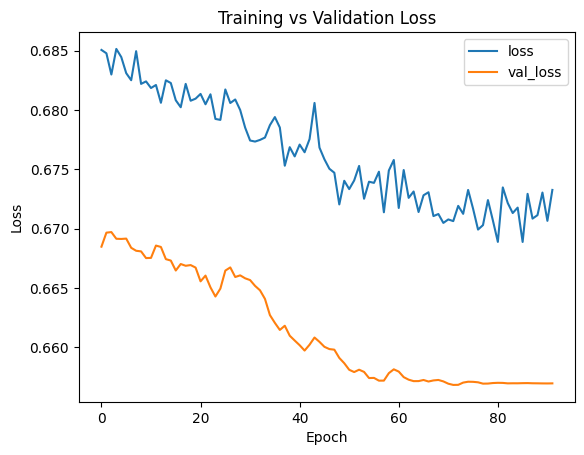

VAL (tuned): {'acc': 0.6923076923076923, 'f1_macro': 0.6904761904761905, 'roc_auc': 0.6190476190476191, 'rmse_prob': 0.48163555897165033, 'rmse_hard': 0.5547001962252291, 'classification_report': '              precision    recall  f1-score   support\n\n           0      0.667     0.667     0.667        12\n           1      0.714     0.714     0.714        14\n\n    accuracy                          0.692        26\n   macro avg      0.690     0.690     0.690        26\nweighted avg      0.692     0.692     0.692        26\n', 'confusion_matrix': [[8, 4], [4, 10]]}
VAL (0.5):   {'acc': 0.6538461538461539, 'f1_macro': 0.6067226890756303, 'roc_auc': 0.6190476190476191, 'rmse_prob': 0.48163555897165033, 'rmse_hard': 0.5883484054145521, 'classification_report': '              precision    recall  f1-score   support\n\n           0      0.800     0.333     0.471        12\n           1      0.619     0.929     0.743        14\n\n    accuracy                          0.654        26\n   mac

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
# ============================================================
# LSTM (single hold-out: Train -> Val -> retrain on Train+Val -> Test)
# Assumes df already has a binary 'target' column and a datetime index.
#
# - Train on full Train, validate on Val (choose threshold on Val)
# - Retrain on Train+Val (no test peeking), evaluate once on Test
# - Includes RMSE metrics (√Brier on probabilities and RMSE on hard labels)
# ============================================================

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --------- Configurable features ---------
FEATURES = ["Last Price","p_state0","p_state1","p_state2","spi_6"]

# --------- Split & metrics helpers ---------
def make_static_splits(df: pd.DataFrame, test_start: str|pd.Timestamp):
    m = df.index >= pd.to_datetime(test_start)
    return df.loc[~m].copy(), df.loc[m].copy()

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
    return float(np.sqrt(np.mean((y_pred - y_true) ** 2)))

def best_threshold(y_true, proba, metric="f1_macro"):
    grid = np.linspace(0.05, 0.95, 181)
    best_t, best = 0.5, -1.0
    for t in grid:
        pred = (proba >= t).astype(int)
        score = f1_score(y_true, pred, average="macro") if metric=="f1_macro" else f1_score(y_true, pred)
        if score > best:
            best, best_t = score, t
    return float(best_t)

def safe_logloss(y_true, proba):
    # clip to avoid log(0) under any version
    p = np.clip(np.asarray(proba, dtype=float), 1e-7, 1-1e-7)
    return float(log_loss(y_true, p, labels=[0, 1]))

def _class_weight_from_labels(y):
    # inverse-frequency weights normalized s.t. average weight ≈ 1
    y = np.asarray(y, int)
    classes, counts = np.unique(y, return_counts=True)
    K = len(classes); total = counts.sum()
    return {int(c): float(total/(K*cnt)) for c, cnt in zip(classes, counts)}

# --------- Sequences & model ---------
def make_sequences(df: pd.DataFrame, lookback: int, feature_cols, target_col="target"):
    """
    Build (X, y) where each X[i] is a window of length `lookback` ending at t-1,
    and y[i] is the target at time t (no look-ahead).
    """
    X, y = [], []
    V = df[feature_cols].values
    t = df[target_col].values
    for i in range(lookback, len(df)):
        X.append(V[i-lookback:i])
        y.append(t[i])
    return np.array(X), np.array(y)

def build_lstm(input_dim, lookback, units=64, dropout=0.2, lr=1e-3):
    m = keras.Sequential([
        layers.Input(shape=(lookback, input_dim)),
        layers.LSTM(units, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(1, activation="sigmoid")
    ])
    m.compile(optimizer=keras.optimizers.Adam(lr),
              loss="binary_crossentropy",
              metrics=["accuracy"])
    return m

# --------- Core training / evaluation blocks ---------
def fit_lstm_train_val(
    df_train: pd.DataFrame,
    df_val: pd.DataFrame,
    feature_cols=FEATURES,
    target_col="target",
    lookback=26,
    class_weight="balanced",  # "balanced" -> auto inverse-freq; or pass a dict {0:w0,1:w1}; or None
    epochs=50,
    batch_size=64,
    patience=5
):
    """
    Fit scaler on TRAIN, train LSTM on TRAIN sequences with early-stopping on VAL sequences.
    Return: model, scaler, y_val_seq, proba_val, val_metrics_at_0p5
    """
    # Clean
    df_train = df_train.dropna(subset=feature_cols + [target_col]).copy()
    df_val   = df_val.dropna(subset=feature_cols + [target_col]).copy()

    # Scale on TRAIN only
    scaler = StandardScaler().fit(df_train[feature_cols])
    tr = df_train.copy(); va = df_val.copy()
    tr[feature_cols] = scaler.transform(tr[feature_cols])
    va[feature_cols] = scaler.transform(va[feature_cols])

    # Sequences
    X_tr, y_tr = make_sequences(tr, lookback, feature_cols, target_col)
    X_va, y_va = make_sequences(va, lookback, feature_cols, target_col)
    if len(X_tr) == 0 or len(X_va) == 0:
        raise ValueError("Not enough data to form sequences. Reduce lookback or provide more rows.")

    # Class weights
    cw = None
    if class_weight == "balanced":
        cw = _class_weight_from_labels(y_tr)
    elif isinstance(class_weight, dict):
        cw = class_weight

    # Train
    model = build_lstm(input_dim=X_tr.shape[2], lookback=lookback)
    es = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True, monitor="val_loss")
    model.fit(
        X_tr, y_tr,
        epochs=epochs, batch_size=batch_size,
        validation_data=(X_va, y_va),
        callbacks=[es], verbose=0,
        class_weight=cw
    )

    history = model.fit(
    X_tr, y_tr,
    validation_data=(X_va, y_va),
    epochs=500,
    batch_size=64,
    shuffle=False,  # time series
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)
      ],
    )

    import pandas as pd, matplotlib.pyplot as plt
    pd.DataFrame(history.history)[["loss","val_loss"]].plot()
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs Validation Loss")
    plt.show()


    # Validation outputs & metrics at threshold 0.5
    proba_va = model.predict(X_va, verbose=0).ravel()
    pred_va  = (proba_va >= 0.5).astype(int)
    val_metrics_0p5 = {
        "acc": float(accuracy_score(y_va, pred_va)),
        "f1_macro": float(f1_score(y_va, pred_va, average="macro")),
        "roc_auc": float(roc_auc_score(y_va, proba_va)) if len(np.unique(y_va)) == 2 else np.nan,
        "rmse_prob": rmse(y_va, proba_va),
        "rmse_hard": rmse(y_va, pred_va.astype(float)),
        "classification_report": classification_report(y_va, pred_va, digits=3),
        "confusion_matrix": confusion_matrix(y_va, pred_va).tolist()
    }
    return model, scaler, y_va, proba_va, val_metrics_0p5

def fit_lstm_final_on_trv(
    df_trv: pd.DataFrame,
    feature_cols=FEATURES,
    target_col="target",
    lookback=26,
    class_weight="balanced",
    epochs=50,
    batch_size=64,
    patience=5
):
    """
    Retrain LSTM on TRAIN+VAL with an internal holdout (from the tail of trv sequences) for early-stopping.
    """
    df_trv = df_trv.dropna(subset=feature_cols + [target_col]).copy()

    scaler = StandardScaler().fit(df_trv[feature_cols])
    trv = df_trv.copy()
    trv[feature_cols] = scaler.transform(trv[feature_cols])

    X_trv, y_trv = make_sequences(trv, lookback, feature_cols, target_col)
    if len(X_trv) == 0:
        raise ValueError("Not enough data in Train+Val to form sequences. Reduce lookback.")

    # small internal validation from tail of Train+Val (no Test peeking)
    monitor_k = max( min( max(len(X_trv)//10, 32), 256 ), 16 )
    monitor_k = min(monitor_k, len(X_trv)//5) if len(X_trv) >= 5 else 0
    if monitor_k > 0:
        X_trv_train, y_trv_train = X_trv[:-monitor_k], y_trv[:-monitor_k]
        X_trv_valm,  y_trv_valm  = X_trv[-monitor_k:], y_trv[-monitor_k:]
        val_monitor = (X_trv_valm, y_trv_valm)
    else:
        X_trv_train, y_trv_train = X_trv, y_trv
        val_monitor = None

    cw = None
    if class_weight == "balanced":
        cw = _class_weight_from_labels(y_trv_train)
    elif isinstance(class_weight, dict):
        cw = class_weight

    model = build_lstm(input_dim=X_trv.shape[2], lookback=lookback)
    es = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True, monitor="val_loss")
    model.fit(
        X_trv_train, y_trv_train,
        epochs=epochs, batch_size=batch_size,
        validation_data=val_monitor,
        callbacks=[es], verbose=0,
        class_weight=cw
    )
    return model, scaler

def eval_lstm_on_split(model, scaler, df_split, feature_cols=FEATURES, target_col="target", lookback=26, threshold=0.5):
    df_split = df_split.dropna(subset=feature_cols + [target_col]).copy()
    df_split[feature_cols] = scaler.transform(df_split[feature_cols])

    X, y = make_sequences(df_split, lookback, feature_cols, target_col)
    if len(X) == 0:
        raise ValueError("Not enough data in this split to form sequences at the chosen lookback.")
    proba = model.predict(X, verbose=0).ravel()
    pred  = (proba >= threshold).astype(int)

    metrics = {
        "acc": float(accuracy_score(y, pred)),
        "f1_macro": float(f1_score(y, pred, average="macro")),
        "roc_auc": float(roc_auc_score(y, proba)) if len(np.unique(y)) == 2 else np.nan,
        "rmse_prob": rmse(y, proba),
        "rmse_hard": rmse(y, pred.astype(float)),
        "classification_report": classification_report(y, pred, digits=3),
        "confusion_matrix": confusion_matrix(y, pred).tolist()
    }
    return metrics, y, proba, pred

# --------- End-to-end (no CV; Train -> Val -> retrain -> Test) ---------
def run_holdout_lstm_single(
    df: pd.DataFrame,
    test_start: str|pd.Timestamp,
    feature_cols=FEATURES,
    target_col="target",
    lookback=26,
    val_span: int|None = None,      # if None -> ~10% bounded in [26, 52]
    class_weight="balanced",        # "balanced", dict, or None
    epochs=50,
    batch_size=64,
    patience=5,
    tune_threshold: bool = True,
    tune_metric: str = "f1_macro"   # which metric to optimize when picking threshold
):
    # 0) Sort; basic cleaning deferred to child funcs to avoid accidental leakage
    df = df.sort_index()

    # 1) Train/Val/Test split
    trainval, test = make_static_splits(df, test_start)
    if val_span is None:
        val_span = min(52, max(26, len(trainval)//10))
    val   = trainval.iloc[-val_span:].copy()
    train = trainval.iloc[:-val_span].copy()

    # 2) Train on full Train, validate on Val (get raw proba for threshold tuning)
    model_tr, scaler_tr, y_va, proba_va, val_metrics_0p5 = fit_lstm_train_val(
        train, val,
        feature_cols=feature_cols, target_col=target_col,
        lookback=lookback,
        class_weight=class_weight,
        epochs=epochs, batch_size=batch_size, patience=patience
    )

    # 3) Choose threshold on Val (optional)
    t_star = 0.5
    if tune_threshold:
        t_star = best_threshold(y_va, proba_va, metric=tune_metric)

    # Recompute Val metrics at tuned threshold for reporting
    # (reuse trained model_tr + scaler_tr to avoid re-fitting)
    df_val_scaled = val.dropna(subset=feature_cols + [target_col]).copy()
    df_val_scaled[feature_cols] = scaler_tr.transform(df_val_scaled[feature_cols])
    X_va2, y_va2 = make_sequences(df_val_scaled, lookback, feature_cols, target_col)
    proba_va2 = model_tr.predict(X_va2, verbose=0).ravel()
    pred_va2  = (proba_va2 >= t_star).astype(int)
    val_metrics_tuned = {
        "acc": float(accuracy_score(y_va2, pred_va2)),
        "f1_macro": float(f1_score(y_va2, pred_va2, average="macro")),
        "roc_auc": float(roc_auc_score(y_va2, proba_va2)) if len(np.unique(y_va2)) == 2 else np.nan,
        "rmse_prob": rmse(y_va2, proba_va2),
        "rmse_hard": rmse(y_va2, pred_va2.astype(float)),
        "classification_report": classification_report(y_va2, pred_va2, digits=3),
        "confusion_matrix": confusion_matrix(y_va2, pred_va2).tolist()
    }

    # 4) Retrain on Train+Val, evaluate once on Test using t_star (no test peeking)
    trv = pd.concat([train, val]).copy()
    model_final, scaler_final = fit_lstm_final_on_trv(
        trv,
        feature_cols=feature_cols, target_col=target_col,
        lookback=lookback,
        class_weight=class_weight,
        epochs=epochs, batch_size=batch_size, patience=patience
    )
    test_metrics, *_ = eval_lstm_on_split(
        model_final, scaler_final, test,
        feature_cols=feature_cols, target_col=target_col,
        lookback=lookback, threshold=t_star
    )

    return {
        "val_metrics_tuned": val_metrics_tuned,
        "val_metrics_at_0p5": val_metrics_0p5,
        "test_metrics": test_metrics,
        "threshold_used": float(t_star),
        "splits": {
            "train": (train.index.min(), train.index.max()),
            "val":   (val.index.min(),   val.index.max()),
            "test":  (test.index.min(),  test.index.max())
        },
        "feature_cols": list(feature_cols),
        "lookback": lookback
    }

# ----------------------------
# Example usage (uncomment)
# ----------------------------
data.index = pd.to_datetime(data["date"])
data = data.sort_index()
out = run_holdout_lstm_single(
    data,
    test_start="2018-01-01",
    feature_cols=["spi_6"],
    target_col="target",
    lookback=26,
    val_span=None,            # or set e.g., 52
    class_weight="balanced",  # or pass dict {0: w0, 1: w1} or None
    epochs=500, batch_size=64, patience=5,
    tune_threshold=True, tune_metric="f1_macro"
)
print("VAL (tuned):", out["val_metrics_tuned"])
print("VAL (0.5):  ", out["val_metrics_at_0p5"])
print("TEST:       ", out["test_metrics"])
print("Threshold:  ", out["threshold_used"])


In [51]:
# ============================================================
# LSTM feature-subset search (single hold-out; pick subset by LOG LOSS)
# - Enumerates ALL non-empty feature combinations from CANDIDATE_FEATURES
# - Trains on Train, validates on Val (choose subset with lowest log loss)
# - Optionally retrains on Train+Val and reports Test log loss for top-K subsets
#
# Assumes:
#   - df already has a binary 'target' column
#   - df has a datetime index (or set df.index = pd.to_datetime(df["date"]))
# ============================================================

import itertools, random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, f1_score
from tensorflow import keras
from tensorflow.keras import layers

# ---------- basic helpers ----------
def make_static_splits(df: pd.DataFrame, test_start: str|pd.Timestamp):
    m = df.index >= pd.to_datetime(test_start)
    return df.loc[~m].copy(), df.loc[m].copy()

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
    return float(np.sqrt(np.mean((y_pred - y_true) ** 2)))

def _class_weight_from_labels(y):
    y = np.asarray(y, int)
    classes, counts = np.unique(y, return_counts=True)
    K = len(classes); total = counts.sum()
    return {int(c): float(total/(K*cnt)) for c, cnt in zip(classes, counts)}

def best_threshold(y_true, proba, metric="f1_macro"):
    # not used for log loss selection, but handy to keep
    grid = np.linspace(0.05, 0.95, 181)
    best_t, best = 0.5, -1.0
    for t in grid:
        pred = (proba >= t).astype(int)
        score = f1_score(y_true, pred, average="macro") if metric=="f1_macro" else f1_score(y_true, pred)
        if score > best:
            best, best_t = score, t
    return float(best_t)

# ---------- sequences & model ----------
def make_sequences(df: pd.DataFrame, lookback: int, feature_cols, target_col="target"):
    X, y = [], []
    V = df[feature_cols].values
    t = df[target_col].values
    for i in range(lookback, len(df)):
        X.append(V[i-lookback:i])
        y.append(t[i])
    return np.array(X), np.array(y)

def build_lstm(input_dim, lookback, units=64, dropout=0.2, lr=1e-3):
    m = keras.Sequential([
        layers.Input(shape=(lookback, input_dim)),
        layers.LSTM(units, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(1, activation="sigmoid")
    ])
    m.compile(optimizer=keras.optimizers.Adam(lr),
              loss="binary_crossentropy",
              metrics=["accuracy"])
    return m

# ---------- scaling utilities ----------
def _split_scale_cols(feature_cols, keep_prefixes=("p_state",)):
    to_scale = [c for c in feature_cols if not any(c.startswith(p) for p in keep_prefixes)]
    return to_scale

def _fit_transform(train_df, other_df, feature_cols, keep_prefixes=("p_state",)):
    to_scale = _split_scale_cols(feature_cols, keep_prefixes)
    scaler = StandardScaler().fit(train_df[to_scale]) if len(to_scale) else None
    tr = train_df.copy(); ot = other_df.copy()
    if scaler is not None:
        tr[to_scale] = scaler.transform(tr[to_scale])
        ot[to_scale] = scaler.transform(ot[to_scale])
    return tr, ot, scaler, to_scale

def _transform_with(scaler, df, to_scale):
    if scaler is None or not to_scale:
        return df.copy()
    out = df.copy()
    out[to_scale] = scaler.transform(out[to_scale])
    return out
def safe_logloss(y_true, proba):
    """Version-agnostic log loss: clips probs and always passes labels=[0,1]."""
    p = np.clip(np.asarray(proba, dtype=float), 1e-7, 1-1e-7)
    y = np.asarray(y_true, dtype=int)
    return float(log_loss(y, p, labels=[0, 1]))

# ---------- core training on a given subset ----------
def _train_eval_subset(train_df, val_df, feature_cols, target_col="target",
                       lookback=26, units=64, dropout=0.2, lr=1e-3,
                       patience=5, batch_size=64, epochs=50,
                       class_weight_mode="balanced", keep_prefixes=("p_state",)):
    # clean
    cols_needed = feature_cols + [target_col]
    train_df = train_df.dropna(subset=cols_needed).copy()
    val_df   = val_df.dropna(subset=cols_needed).copy()
    if train_df.empty or val_df.empty:
        return None  # not enough data

    # scale (price/SPI by default; keep p_state* raw)
    tr, va, scaler, to_scale = _fit_transform(train_df, val_df, feature_cols, keep_prefixes)

    # sequences
    X_tr, y_tr = make_sequences(tr, lookback, feature_cols, target_col)
    X_va, y_va = make_sequences(va, lookback, feature_cols, target_col)
    if len(X_tr) == 0 or len(X_va) == 0:
        return None

    # class weights
    cw = None
    if class_weight_mode == "balanced":
        cw = _class_weight_from_labels(y_tr)
    elif isinstance(class_weight_mode, dict):
        cw = class_weight_mode

    # model
    model = build_lstm(input_dim=X_tr.shape[2], lookback=lookback, units=units, dropout=dropout, lr=lr)
    es = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True, monitor="val_loss")
    model.fit(
        X_tr, y_tr,
        epochs=epochs, batch_size=batch_size,
        validation_data=(X_va, y_va),
        callbacks=[es], verbose=0,
        class_weight=cw
    )
    # validation probabilities/metrics
    proba_va = model.predict(X_va, verbose=0).ravel()
    # robust log loss (uses labels=[0,1] even if one class absent)
    val_logloss = safe_logloss(y_va, proba_va)
    # some extra metrics for info
    val_auc = float(roc_auc_score(y_va, proba_va)) if len(np.unique(y_va)) == 2 else np.nan
    val_acc = float(accuracy_score(y_va, (proba_va >= 0.5).astype(int)))
    val_f1  = float(f1_score(y_va, (proba_va >= 0.5).astype(int), average="macro"))
    val_rmse_prob = rmse(y_va, proba_va)

    return {
        "model": model,
        "scaler": scaler,
        "to_scale": to_scale,
        "y_va": y_va,
        "proba_va": proba_va,
        "val_logloss": val_logloss,
        "val_auc": val_auc,
        "val_acc": val_acc,
        "val_f1_macro": val_f1,
        "val_rmse_prob": val_rmse_prob
    }

# ---------- final retrain on Train+Val and test ----------
def _retrain_and_test(df_trv, df_test, feature_cols, target_col="target",
                      lookback=26, units=64, dropout=0.2, lr=1e-3,
                      patience=5, batch_size=64, epochs=50,
                      class_weight_mode="balanced", keep_prefixes=("p_state",)):
    # clean
    cols_needed = feature_cols + [target_col]
    df_trv  = df_trv.dropna(subset=cols_needed).copy()
    df_test = df_test.dropna(subset=cols_needed).copy()
    if df_trv.empty or df_test.empty:
        return None

    # scale on Train+Val
    to_scale = _split_scale_cols(feature_cols, keep_prefixes)
    scaler = StandardScaler().fit(df_trv[to_scale]) if len(to_scale) else None
    trv  = _transform_with(scaler, df_trv, to_scale)
    test = _transform_with(scaler, df_test, to_scale)

    # sequences
    X_trv, y_trv = make_sequences(trv,  lookback, feature_cols, target_col)
    X_te,  y_te  = make_sequences(test, lookback, feature_cols, target_col)
    if len(X_trv) == 0 or len(X_te) == 0:
        return None

    # small internal val from trv tail for early stopping
    monitor_k = max(min(max(len(X_trv)//10, 32), 256), 16)
    monitor_k = min(monitor_k, len(X_trv)//5) if len(X_trv) >= 5 else 0
    if monitor_k > 0:
        X_tr, y_tr = X_trv[:-monitor_k], y_trv[:-monitor_k]
        X_vm, y_vm = X_trv[-monitor_k:], y_trv[-monitor_k:]
        val_monitor = (X_vm, y_vm)
    else:
        X_tr, y_tr = X_trv, y_trv
        val_monitor = None

    cw = None
    if class_weight_mode == "balanced":
        cw = _class_weight_from_labels(y_tr)
    elif isinstance(class_weight_mode, dict):
        cw = class_weight_mode

    # model
    model = build_lstm(input_dim=X_trv.shape[2], lookback=lookback, units=units, dropout=dropout, lr=lr)
    es = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True, monitor="val_loss")
    model.fit(
        X_tr, y_tr,
        epochs=epochs, batch_size=64,
        validation_data=val_monitor,
        callbacks=[es], verbose=0,
        class_weight=cw
    )

    proba_te = model.predict(X_te, verbose=0).ravel()
    test_logloss = safe_logloss(y_te, proba_te)
    test_auc = float(roc_auc_score(y_te, proba_te)) if len(np.unique(y_te)) == 2 else np.nan
    test_acc = float(accuracy_score(y_te, (proba_te >= 0.5).astype(int)))
    test_f1  = float(f1_score(y_te, (proba_te >= 0.5).astype(int), average="macro"))
    test_rmse_prob = rmse(y_te, proba_te)

    return {
        "test_logloss": test_logloss,
        "test_auc": test_auc,
        "test_acc": test_acc,
        "test_f1_macro": test_f1,
        "test_rmse_prob": test_rmse_prob
    }

# ---------- search over ALL feature subsets ----------
def grid_search_feature_subsets_lstm_holdout(
    df: pd.DataFrame,
    test_start: str|pd.Timestamp,
    CANDIDATE_FEATURES: list[str] | None = None,
    target_col: str = "target",
    lookback: int = 26,
    units: int = 64,
    dropout: float = 0.2,
    lr: float = 1e-3,
    patience: int = 5,
    batch_size: int = 64,
    epochs: int = 50,
    class_weight_mode: str | dict | None = "balanced",
    keep_prefixes: tuple[str,...] = ("p_state",),
    max_subsets: int | None = None,      # set to e.g. 2000 to cap runtime
    top_k_test: int = 5,                 # retrain+test only for top-K by val logloss
    random_seed: int = 42
):
    """
    Returns a dict with:
      - 'ranked': DataFrame of all tried subsets sorted by val_logloss
      - 'best_subset': best feature list (by val_logloss)
      - 'best_val': metrics dict for the best subset
      - 'topk_test': list of dicts with test metrics for top-K subsets
    """
    df = df.sort_index().copy()
    trainval, test = make_static_splits(df, test_start)

    # candidate features (auto-detect numeric columns if not provided)
    if CANDIDATE_FEATURES is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        CANDIDATE_FEATURES = [c for c in numeric_cols if c != target_col]

    # enumerate ALL non-empty subsets
    all_subsets = []
    for r in range(1, len(CANDIDATE_FEATURES) + 1):
        for comb in itertools.combinations(CANDIDATE_FEATURES, r):
            all_subsets.append(list(comb))

    # optional cap to avoid explosion
    random.seed(random_seed)
    if max_subsets is not None and len(all_subsets) > max_subsets:
        all_subsets = random.sample(all_subsets, max_subsets)

    rows = []
    cache_best = {"subset": None, "val": None}

    for subset in all_subsets:
        res = _train_eval_subset(
            trainval.iloc[:-min(52, max(26, len(trainval)//10))],   # Train
            trainval.iloc[-min(52, max(26, len(trainval)//10)):],   # Val
            feature_cols=subset,
            target_col=target_col,
            lookback=lookback, units=units, dropout=dropout, lr=lr,
            patience=patience, batch_size=batch_size, epochs=epochs,
            class_weight_mode=class_weight_mode, keep_prefixes=keep_prefixes
        )
        if res is None:
            continue

        row = {
            "subset": tuple(subset),
            "k": len(subset),
            "val_logloss": res["val_logloss"],
            "val_auc": res["val_auc"],
            "val_acc": res["val_acc"],
            "val_f1_macro": res["val_f1_macro"],
            "val_rmse_prob": res["val_rmse_prob"]
        }
        rows.append(row)

        if (cache_best["val"] is None) or (row["val_logloss"] < cache_best["val"]["val_logloss"]):
            cache_best["subset"] = subset
            cache_best["val"] = row

    if not rows:
        raise RuntimeError("No valid subsets could be trained (not enough data per subset/lookback).")

    ranked = pd.DataFrame(rows).sort_values("val_logloss").reset_index(drop=True)
    best_subset = list(ranked.loc[0, "subset"])
    best_val_row = ranked.loc[0].to_dict()

    # retrain on Train+Val and evaluate on Test for top-K subsets
    topk = min(top_k_test, len(ranked))
    topk_test = []
    trv = trainval  # full Train+Val

    for i in range(topk):
        subset_i = list(ranked.loc[i, "subset"])
        test_res = _retrain_and_test(
            trv, test,
            feature_cols=subset_i, target_col=target_col,
            lookback=lookback, units=units, dropout=dropout, lr=lr,
            patience=patience, batch_size=batch_size, epochs=epochs,
            class_weight_mode=class_weight_mode, keep_prefixes=keep_prefixes
        )
        if test_res is not None:
            topk_test.append({"subset": tuple(subset_i), **test_res})

    return {
        "ranked": ranked,
        "best_subset": best_subset,
        "best_val": best_val_row,
        "topk_test": topk_test
    }

# ----------------------------
# Example usage (uncomment)
# ----------------------------
data.index = pd.to_datetime(data["date"])
data = data.sort_index()
#
# # Define candidate features explicitly (recommended)
CANDIDATE_FEATURES = ["Last Price","top_state","spi_6",
                      "ret_1"]
#
out = grid_search_feature_subsets_lstm_holdout(
    data,
    test_start="2018-01-01",
    CANDIDATE_FEATURES=CANDIDATE_FEATURES,
    target_col="target",
    lookback=26,
    units=64, dropout=0.2, lr=1e-3,
    patience=5, batch_size=64, epochs=50,
    class_weight_mode="balanced",
    keep_prefixes=("p_state",),   # keep p_state* unscaled
    max_subsets=1024,             # cap if feature count is large
    top_k_test=5
)
#
print("Best subset by VAL logloss:", out["best_subset"])
print("Best VAL row:", out["best_val"])
print("Top-K TEST results:")
for r in out["topk_test"]:
    print(r)


Best subset by VAL logloss: ['spi_6']
Best VAL row: {'subset': ('spi_6',), 'k': 1, 'val_logloss': 0.6671536790350419, 'val_auc': 0.625, 'val_acc': 0.6538461538461539, 'val_f1_macro': 0.6067226890756303, 'val_rmse_prob': 0.48685812486001484}
Top-K TEST results:
{'subset': ('spi_6',), 'test_logloss': 0.6925327106857391, 'test_auc': 0.5387801868499912, 'test_acc': 0.5447154471544715, 'test_f1_macro': 0.5432360742705571, 'test_rmse_prob': 0.4996381821083819}
{'subset': ('Last Price', 'top_state'), 'test_logloss': 0.6919179675906035, 'test_auc': 0.5390445972148775, 'test_acc': 0.5447154471544715, 'test_f1_macro': 0.5422647527910687, 'test_rmse_prob': 0.49938506581254377}
{'subset': ('top_state', 'spi_6'), 'test_logloss': 0.6921368318806327, 'test_auc': 0.5294670662201069, 'test_acc': 0.5338753387533876, 'test_f1_macro': 0.5323607427055703, 'test_rmse_prob': 0.4994946195616021}
{'subset': ('Last Price', 'top_state', 'spi_6'), 'test_logloss': 0.6932942997503005, 'test_auc': 0.5208002820377226

In [32]:
data

,date,spi_6,p_state0,p_state1,p_state2,Last Price,price_date_used,fallback_days,ret_1,top_state,next_ret,target
date,,,,,,,,,,,,
1992-01-12,1992-01-12,-0.676211,0.188472,0.778493,0.033035,2.43,1992-01-10,2.0,0.016736,1,0.020576,1
1992-01-19,1992-01-19,-0.408163,0.042357,0.918067,0.039576,2.48,1992-01-17,2.0,0.020576,1,0.028226,1
1992-01-26,1992-01-26,-0.149762,0.031910,0.927547,0.040544,2.55,1992-01-24,2.0,0.028226,1,0.007843,1
1992-02-02,1992-02-02,-0.012210,0.031731,0.926709,0.041559,2.57,1992-01-31,2.0,0.007843,1,0.000000,0
1992-02-09,1992-02-09,-0.154111,0.031869,0.927580,0.040551,2.57,1992-02-07,2.0,0.000000,1,-0.007782,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-29,2025-06-29,-0.317970,0.047144,0.919293,0.033563,4.00,2025-06-27,2.0,-0.014778,1,0.025000,1
2025-07-06,2025-07-06,-0.346593,0.053727,0.912975,0.033298,4.10,2025-07-03,3.0,0.025000,1,-0.056098,0
2025-07-13,2025-07-13,-0.113659,0.039652,0.926234,0.034114,3.87,2025-07-11,2.0,-0.056098,1,0.020672,1
